In [1]:
import numpy as np
import random

# -------------------------------
# 환경 설정
# -------------------------------

num_tasks = 5      # 태스크 수
num_agents = 3     # 에이전트 수
num_actions = 2    # 각 에이전트가 선택할 수 있는 행동 수

# 태스크 난이도 또는 요구 리소스
task_difficulty = np.random.randint(1, 10, size=num_tasks)

# 에이전트 리소스 (예: 처리 능력)
agent_capacity = np.random.randint(5, 15, size=num_agents)

# -------------------------------
# 1️⃣ 라우팅 레이어 (Routing)
# -------------------------------

def route_tasks(task_difficulty, agent_capacity):
    """
    단순 라우팅 예시: 
    각 태스크를 처리 가능 용량이 충분한 에이전트에 무작위 할당
    """
    routing = np.zeros((num_tasks, num_agents))  # x_{i,j}
    
    for i, difficulty in enumerate(task_difficulty):
        possible_agents = [j for j, cap in enumerate(agent_capacity) if cap >= difficulty]
        if possible_agents:
            selected_agent = random.choice(possible_agents)
            routing[i, selected_agent] = 1
        else:
            # 처리 불가능 시 가장 여유 있는 에이전트 선택
            selected_agent = np.argmax(agent_capacity)
            routing[i, selected_agent] = 1
    return routing

routing_matrix = route_tasks(task_difficulty, agent_capacity)
print("Routing matrix (x_{i,j}):")
print(routing_matrix)

# -------------------------------
# 2️⃣ 정책 레이어 (Decision / Policy)
# -------------------------------

def agent_policy(agent_id, task_id):
    """
    단순 정책 예시:
    - 행동 0: 빠른 처리, 낮은 정확도
    - 행동 1: 느린 처리, 높은 정확도
    """
    # 예: 태스크 난이도가 높으면 정확도 중심 행동 선택
    if task_difficulty[task_id] > 5:
        action = 1
    else:
        action = 0
    return action

# -------------------------------
# 3️⃣ Joint Routing + Policy 수행
# -------------------------------

results = []
for i in range(num_tasks):
    agent_id = np.argmax(routing_matrix[i])
    action_id = agent_policy(agent_id, i)
    results.append((i, agent_id, action_id))

print("\nTask -> Agent -> Action mapping:")
for r in results:
    print(f"Task {r[0]} -> Agent {r[1]} -> Action {r[2]}")

# -------------------------------
# 4️⃣ 성능 평가 (예시)
# -------------------------------

def evaluate(results):
    """
    간단 평가: 성공률 + 처리 비용
    """
    success = 0
    cost = 0
    for task_id, agent_id, action_id in results:
        # 성공 확률 예시
        prob_success = 0.5 + 0.05 * agent_capacity[agent_id] - 0.05 * task_difficulty[task_id]
        success += prob_success
        
        # 비용 예시: 행동 0 -> 낮음, 행동 1 -> 높음
        cost += 1 if action_id == 0 else 2
    return success/num_tasks, cost

success_rate, total_cost = evaluate(results)
print(f"\nSuccess Rate: {success_rate:.2f}, Total Cost: {total_cost}")


Routing matrix (x_{i,j}):
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

Task -> Agent -> Action mapping:
Task 0 -> Agent 0 -> Action 0
Task 1 -> Agent 1 -> Action 0
Task 2 -> Agent 0 -> Action 0
Task 3 -> Agent 2 -> Action 1
Task 4 -> Agent 1 -> Action 0

Success Rate: 0.68, Total Cost: 6


In [2]:
import numpy as np
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import random

# -------------------------------
# 환경 설정
# -------------------------------
num_tasks = 5
num_agents = 3
num_actions = 2

# 태스크 난이도
task_difficulty = np.random.randint(1, 10, size=num_tasks)
# 에이전트 처리 능력
agent_capacity = np.random.randint(5, 15, size=num_agents)

# -------------------------------
# 1️⃣ 라우팅 레이어 (MIP 최적화)
# -------------------------------
# 목표: 처리 효율 + 에이전트 여유 자원 최대화

model = LpProblem(name="routing_optimization", sense=LpMaximize)

# 변수: x[i,j] = 1 if task i is assigned to agent j
x = [[LpVariable(f"x_{i}_{j}", cat="Binary") for j in range(num_agents)] for i in range(num_tasks)]

# 목표 함수 예시
model += lpSum(
    x[i][j] * (agent_capacity[j] - task_difficulty[i])  # 단순 효율 평가
    for i in range(num_tasks)
    for j in range(num_agents)
)

# 제약 조건: 각 태스크는 하나의 에이전트에만 할당
for i in range(num_tasks):
    model += lpSum(x[i][j] for j in range(num_agents)) == 1

# 제약 조건: 에이전트 용량 초과 불가
for j in range(num_agents):
    model += lpSum(x[i][j]*task_difficulty[i] for i in range(num_tasks)) <= agent_capacity[j]

model.solve()

routing_matrix = np.array([[x[i][j].varValue for j in range(num_agents)] for i in range(num_tasks)])
print("Routing matrix (MIP optimized):")
print(routing_matrix)

# -------------------------------
# 2️⃣ 정책 레이어 (RL 기반 단순화)
# -------------------------------
# Q-learning 스타일 간단 정책
# 상태: 태스크 난이도, agent capacity
# 행동: 0=빠른 처리/낮은 정확도, 1=느린 처리/높은 정확도

Q_table = np.zeros((num_tasks, num_actions))  # 상태별 행동 가치

def rl_policy(task_id, epsilon=0.1):
    # 탐험 vs 활용
    if random.random() < epsilon:
        return random.choice([0,1])
    else:
        return np.argmax(Q_table[task_id])

def update_q(task_id, action, reward, alpha=0.5):
    # 단순 Q 업데이트
    Q_table[task_id, action] = (1-alpha)*Q_table[task_id, action] + alpha*reward

# -------------------------------
# 3️⃣ Joint Routing + RL Policy 수행
# -------------------------------
results = []
for i in range(num_tasks):
    agent_id = np.argmax(routing_matrix[i])
    action_id = rl_policy(i)
    
    # 간단 보상 예시: 난이도가 높으면 정확도 중심 행동(1) 보상이 높음
    reward = 1 + 0.5*task_difficulty[i] if action_id==1 else 1
    update_q(i, action_id, reward)
    
    results.append((i, agent_id, action_id, reward))

print("\nTask -> Agent -> Action -> Reward mapping:")
for r in results:
    print(f"Task {r[0]} -> Agent {r[1]} -> Action {r[2]} -> Reward {r[3]}")

# -------------------------------
# 4️⃣ 성능 평가
# -------------------------------
total_reward = sum(r[3] for r in results)
print(f"\nTotal Reward (System Performance): {total_reward}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/dibaeck/miniconda3/envs/agent/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/2ecfe594c29f43df90ab0ed5cf528189-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/2ecfe594c29f43df90ab0ed5cf528189-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 88 RHS
At line 97 BOUNDS
At line 113 ENDATA
Problem MODEL has 8 rows, 15 columns and 30 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 30.0833 - 0.00 seconds
Cgl0003I 2 fixed, 0 tightened bounds, 1 strengthened rows, 8 substitutions
Cgl0004I processed model has 4 rows, 7 columns (7 integer (7 of which binary)) and 12 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -26
Cbc0038I Before m

In [3]:
import numpy as np
import random
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

# -------------------------------
# 1️⃣ 환경 설정
# -------------------------------
num_tasks = 5
num_agents = 3
num_actions = 2

task_difficulty = np.random.randint(1, 10, size=num_tasks)
agent_capacity = np.random.randint(5, 15, size=num_agents)

# -------------------------------
# 2️⃣ 라우팅 레이어 (MIP)
# -------------------------------
def routing_mip(tasks, agents):
    model = LpProblem(name="routing_optimization", sense=LpMaximize)
    x = [[LpVariable(f"x_{i}_{j}", cat="Binary") for j in range(num_agents)] for i in range(num_tasks)]
    
    # 목표: 에이전트 여유 자원 + 효율
    model += lpSum(x[i][j] * (agents[j] - tasks[i]) for i in range(num_tasks) for j in range(num_agents))
    
    # 제약: 각 태스크 하나의 에이전트에만 할당
    for i in range(num_tasks):
        model += lpSum(x[i][j] for j in range(num_agents)) == 1
    # 제약: 에이전트 용량 초과 금지
    for j in range(num_agents):
        model += lpSum(x[i][j]*tasks[i] for i in range(num_tasks)) <= agents[j]
    
    model.solve()
    return np.array([[x[i][j].varValue for j in range(num_agents)] for i in range(num_tasks)])

routing_matrix = routing_mip(task_difficulty, agent_capacity)
print("Routing matrix (MIP optimized):")
print(routing_matrix)

# -------------------------------
# 3️⃣ 정책 레이어 (RL 기반 단순화)
# -------------------------------
Q_table = np.zeros((num_tasks, num_actions))

def rl_policy(task_id, epsilon=0.1):
    if random.random() < epsilon:
        return random.choice([0,1])
    return np.argmax(Q_table[task_id])

def update_q(task_id, action, reward, alpha=0.5):
    Q_table[task_id, action] = (1-alpha)*Q_table[task_id, action] + alpha*reward

# -------------------------------
# 4️⃣ Joint 실행
# -------------------------------
results = []
for i in range(num_tasks):
    agent_id = np.argmax(routing_matrix[i])
    action_id = rl_policy(i)
    reward = 1 + 0.5*task_difficulty[i] if action_id==1 else 1
    update_q(i, action_id, reward)
    results.append((i, agent_id, action_id, reward))

print("\nTask -> Agent -> Action -> Reward mapping:")
for r in results:
    print(f"Task {r[0]} -> Agent {r[1]} -> Action {r[2]} -> Reward {r[3]}")

# -------------------------------
# 5️⃣ 성능 평가
# -------------------------------
total_reward = sum(r[3] for r in results)
print(f"\nTotal Reward (System Performance): {total_reward}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/dibaeck/miniconda3/envs/agent/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/c73886353adc4bbf9d9a010a8cf6dbe3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/c73886353adc4bbf9d9a010a8cf6dbe3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 87 RHS
At line 96 BOUNDS
At line 112 ENDATA
Problem MODEL has 8 rows, 15 columns and 30 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 46.6 - 0.00 seconds
Cgl0004I processed model has 7 rows, 13 columns (13 integer (13 of which binary)) and 26 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.4
Cbc0038I Pass   1: suminf.    0.40000 (2) obj. -45.2 iterations 3
Cbc0038I Solution found of -38
Cbc0038I Before mini bra

In [4]:
import numpy as np
import random
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

# -------------------------------
# 1️⃣ 환경 설정
# -------------------------------
num_tasks = 5
num_agents = 3
num_actions = 2  # 행동: 0=빠른 처리/낮은 정확도, 1=느린 처리/높은 정확도

task_difficulty = np.random.randint(1, 10, size=num_tasks)
agent_capacity = np.random.randint(5, 15, size=num_agents)

# -------------------------------
# 2️⃣ 라우팅 레이어 (MIP)
# -------------------------------
def routing_mip(tasks, agents):
    model = LpProblem(name="routing_optimization", sense=LpMaximize)
    x = [[LpVariable(f"x_{i}_{j}", cat="Binary") for j in range(num_agents)] for i in range(num_tasks)]
    
    # 목표: 에이전트 여유 자원 + 효율
    model += lpSum(x[i][j] * (agents[j] - tasks[i]) for i in range(num_tasks) for j in range(num_agents))
    
    # 제약: 각 태스크 하나의 에이전트에만 할당
    for i in range(num_tasks):
        model += lpSum(x[i][j] for j in range(num_agents)) == 1
    # 제약: 에이전트 용량 초과 금지
    for j in range(num_agents):
        model += lpSum(x[i][j]*tasks[i] for i in range(num_tasks)) <= agents[j]
    
    model.solve()
    return np.array([[x[i][j].varValue for j in range(num_agents)] for i in range(num_tasks)])

routing_matrix = routing_mip(task_difficulty, agent_capacity)
print("Routing matrix (MIP optimized):")
print(routing_matrix)

# -------------------------------
# 3️⃣ 정책 레이어 (Hierarchical RL + LLM 모듈 호출 시뮬레이션)
# -------------------------------
# Q-table 기반 상위 정책 (태스크 난이도에 따라 행동 전략 선택)
Q_table = np.zeros((num_tasks, num_actions))

def rl_policy(task_id, epsilon=0.1):
    if random.random() < epsilon:
        return random.choice([0,1])
    return np.argmax(Q_table[task_id])

def update_q(task_id, action, reward, alpha=0.5):
    Q_table[task_id, action] = (1-alpha)*Q_table[task_id, action] + alpha*reward

# LLM 모듈 호출 시뮬레이션
def llm_module(task_id, action_id):
    """
    Hierarchical RL 하위 모듈
    - 행동 0: 빠른 처리, 낮은 정확도
    - 행동 1: 느린 처리, 높은 정확도
    """
    base_score = random.random()
    if action_id == 1:
        # 정확도 중심
        return base_score + 0.5
    return base_score

# -------------------------------
# 4️⃣ Joint Routing + Policy + LLM 수행
# -------------------------------
results = []
for i in range(num_tasks):
    agent_id = np.argmax(routing_matrix[i])
    action_id = rl_policy(i)
    
    # 하위 모듈 수행 (LLM 모듈 시뮬레이션)
    reward = llm_module(i, action_id)
    
    # 상위 Q-table 업데이트
    update_q(i, action_id, reward)
    
    results.append((i, agent_id, action_id, reward))

print("\nTask -> Agent -> Action -> Reward mapping:")
for r in results:
    print(f"Task {r[0]} -> Agent {r[1]} -> Action {r[2]} -> Reward {r[3]:.2f}")

# -------------------------------
# 5️⃣ 전체 성능 평가
# -------------------------------
total_reward = sum(r[3] for r in results)
print(f"\nTotal Reward (System Performance): {total_reward:.2f}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/dibaeck/miniconda3/envs/agent/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/7ae38a6574914bbdaedd07e46413e430-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/7ae38a6574914bbdaedd07e46413e430-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 89 RHS
At line 98 BOUNDS
At line 114 ENDATA
Problem MODEL has 8 rows, 15 columns and 30 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 39.4286 - 0.00 seconds
Cgl0004I processed model has 8 rows, 15 columns (15 integer (15 of which binary)) and 30 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.857143
Cbc0038I Pass   1: suminf.    0.57143 (2) obj. -39.2857 iterations 5
Cbc0038I Pass   2: suminf.    0.85714 (2) ob

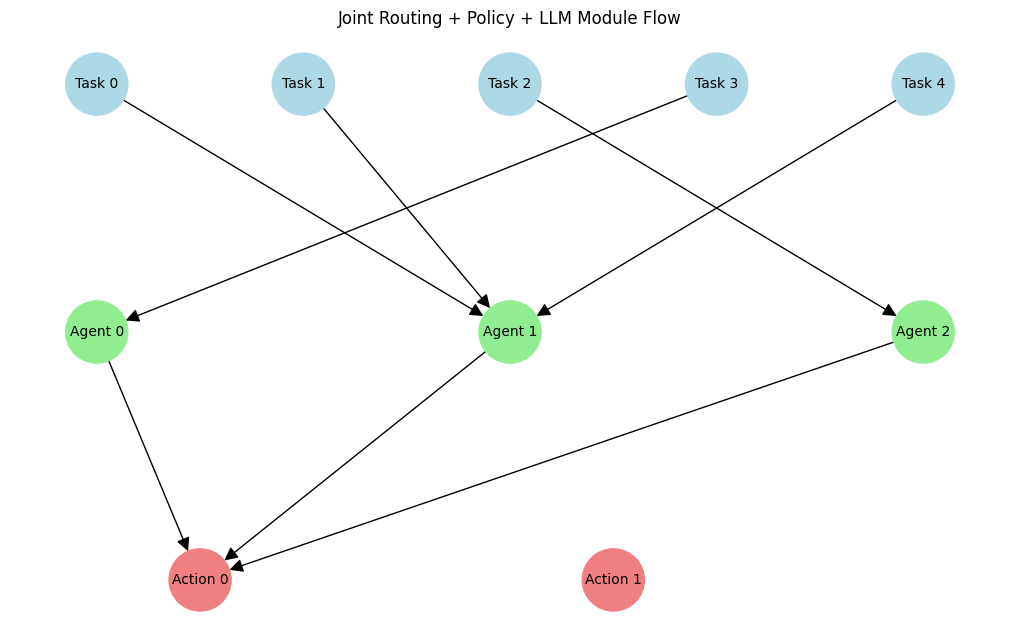

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ 그래프 생성
# -------------------------------
G = nx.DiGraph()

# 노드 추가
tasks = [f"Task {i}" for i in range(num_tasks)]
agents = [f"Agent {j}" for j in range(num_agents)]
actions = [f"Action {k}" for k in range(num_actions)]

# 태스크 노드
for t in tasks:
    G.add_node(t, color='lightblue', layer='task')

# 에이전트 노드
for a in agents:
    G.add_node(a, color='lightgreen', layer='agent')

# 행동 노드
for act in actions:
    G.add_node(act, color='lightcoral', layer='action')

# -------------------------------
# 2️⃣ 에지 연결
# -------------------------------
# 태스크 -> 에이전트 (라우팅)
for i in range(num_tasks):
    agent_id = np.argmax(routing_matrix[i])
    G.add_edge(f"Task {i}", f"Agent {agent_id}")

# 에이전트 -> 행동 (상위 정책 선택)
for i in range(num_tasks):
    action_id = results[i][2]
    agent_id = results[i][1]
    G.add_edge(f"Agent {agent_id}", f"Action {action_id}")

# -------------------------------
# 3️⃣ 시각화
# -------------------------------
pos = {}
# 계층별 y값 설정
layer_y = {'task':3, 'agent':2, 'action':1}
# x값는 노드 수로 분포
for idx, node in enumerate(tasks):
    pos[node] = (idx, layer_y['task'])
for idx, node in enumerate(agents):
    pos[node] = (idx*2, layer_y['agent'])
for idx, node in enumerate(actions):
    pos[node] = (idx*2+0.5, layer_y['action'])

# 색상
colors = [G.nodes[n]['color'] for n in G.nodes()]

plt.figure(figsize=(10,6))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, font_size=10, arrowsize=20)
plt.title("Joint Routing + Policy + LLM Module Flow")
plt.show()


### 노드 계층
- Task → Agent → Action (LLM/하위 모듈)

### 엣지
- 라우팅 결과 → 태스크가 어떤 에이전트에 할당됐는지 표시
- 정책 결과 → 에이전트가 어떤 행동을 선택했는지 표시

### 색상
- Task: 파랑
- Agent: 초록
- Action: 빨강